In [1]:
import tensorflow as tf
import numpy as np

# Генерируем именно мелодию

Мелодия - это музыка, в которой одновременно не звучит несколько нот. Значит, это обычная многоклассовая классификация.

Для этого на выходе хочется иметь именно что распределение. Поэтому вводим 14-ую ноту под названием "пауза".

In [34]:
from songs import *

Songs = []
for i in range(1, 35):
    song = Song('basic midi/track (' + str(i) + ').mid')
    
    if (song.notes.sum(axis=1) <= 1).all():    
        while song.transpose(1):
            pass

        Songs.append(song.notes)
        while song.transpose(-1):
            Songs.append(song.notes)
    
Songs = np.array(Songs)
Songs = np.concatenate([Songs, (Songs.sum(axis=2) == 0)[:, :, None]], axis=2)  # добавление ноты-"пауза"

ERROR! out of range!
ERROR! out of range!
ERROR! out of range!


## Изменения в архитектуре:
квадратичная потеря

In [3]:
# the input data is 128+64 random binary vectors of dimension 13
# the output data has same dimensions; final 128 of vectors must be same as first 128 of input
tf.reset_default_graph()

# Network Parameters
learning_rate = 0.001
batch_size = Songs.shape[0]
num_input = 14       # dimension of one input at moment
timesteps = 128   # timesteps in one sequence
num_transform = 75  # num of lstms in transform layer
num_hidden = 70      # num of lstms in first hidden layer
num_read = 50        # num of lstms in second hidden layer
num_final = 90       # num of lstms in final hidden layer
history_size = 80    # how much previous moments of input is stored

# tf graph input
X = tf.placeholder("float", [batch_size, timesteps, num_input])

# loss will be calculated in the loop as sum of losses on each iteration
loss_op = tf.constant(0.0)

# defining first hidden layer
with tf.variable_scope('first_lstm'):
    first_lstm = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    first_lstm_state = tf.zeros([batch_size, num_hidden]), tf.zeros([batch_size, num_hidden])

# defining second hidden layer
with tf.variable_scope("read_lstm"):
    read_lstm = tf.contrib.rnn.BasicLSTMCell(num_read, forget_bias=1.0)
    read_lstm_state = tf.zeros([batch_size, num_read]), tf.zeros([batch_size, num_read])

# linear transformation of second lstm cell outputs to history size dimension vector
read_w = tf.Variable(tf.random_normal([num_read, history_size]))
read_b = tf.Variable(tf.random_normal([history_size]))

# history is an array of previous (in time) history_size inputs
history = tf.zeros([batch_size, num_input, history_size])

with tf.variable_scope('transform_lstm'):
    transform_lstm = tf.contrib.rnn.BasicLSTMCell(num_transform, forget_bias=1.0)
    transform_lstm_state = tf.zeros([batch_size, num_transform]), tf.zeros([batch_size, num_transform])

# defining common hidden layer
with tf.variable_scope("final_lstm"):
    final_lstm = tf.contrib.rnn.BasicLSTMCell(num_final, forget_bias=1.0)
    final_lstm_state = tf.zeros([batch_size, num_final]), tf.zeros([batch_size, num_final])
    
# linear transformation to final output
final_w = tf.Variable(tf.random_normal([num_final, num_input]))
final_b = tf.Variable(tf.random_normal([num_input]))

# reshaping data to (timesteps, batch_size, num_input)
_X = tf.unstack(X, timesteps, 1)

# time loop
readings_log = []
outputs = []
for t, inp, truth in zip(np.arange(timesteps - 1), _X[:-1], _X[1:]):
    # moving data through lstm layers
    with tf.variable_scope('first_lstm'):
        first_lstm_output, first_lstm_state = first_lstm(inp, first_lstm_state)
    with tf.variable_scope("read_lstm"):
        read_lstm_output, read_lstm_state = read_lstm(first_lstm_output, read_lstm_state)
    
    # linear transformation to vector of history_size length
    read = tf.matmul(read_lstm_output, read_w) + read_b
    # transformation to "probabilities"-kind weights    
    read_proba = tf.nn.softmax(read, 1)
    readings_log.append(read_proba)
    # taking selected data from memory
    memory_retrieve = tf.matmul(history, tf.expand_dims(read_proba, 2))
    
    # rolling history
    history = tf.concat([history[:, :, 1:], tf.expand_dims(inp, 2)], axis=2)
    
    # moving input through transformation layer
    with tf.variable_scope('transform_lstm'):
        transform_lstm_output, transformt_lstm_state = transform_lstm(inp, transform_lstm_state)
    
    # moving through final lstm layer
    with tf.variable_scope("final_lstm"):
        final_lstm_output, final_lstm_state = final_lstm(tf.concat([transform_lstm_output, 
                                                                    tf.squeeze(memory_retrieve, 2)], axis=1), 
                                                         final_lstm_state)
    
    # calculating final ans
    output = tf.matmul(final_lstm_output, final_w) + final_b
    outputs.append(tf.nn.softmax(output, 1))
    
    # calculate loss
    loss_op += tf.reduce_mean(tf.squared_difference(output, truth))
    #tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=truth))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
# optimizing
train_op = tf.contrib.layers.optimize_loss(
                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [4]:
# Start training
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)

sess = tf.Session(config = config)
# Run the initializer
sess.run(init)

losses = []

In [5]:
training_steps = 1000
display_step = 100

for step in range(0, training_steps):
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: Songs})
    
    # Get Loss
    L = sess.run(loss_op, feed_dict={X: Songs})
    losses.append(L)
    
    if step % display_step == 0:
        # Calculate batch loss and accuracy        
        print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(L))

print("Optimization Finished!")

Step 0, Minibatch Loss= 164.6062
Step 100, Minibatch Loss= 6.9385
Step 200, Minibatch Loss= 4.2203
Step 300, Minibatch Loss= 3.3685
Step 400, Minibatch Loss= 2.9524
Step 500, Minibatch Loss= 2.6171
Step 600, Minibatch Loss= 2.4036
Step 700, Minibatch Loss= 2.2442
Step 800, Minibatch Loss= 2.1107
Step 900, Minibatch Loss= 2.0370
Optimization Finished!


In [7]:
print("forgot to print loss on final step: ", L)

forgot to print loss on final step:  1.79736


### Мы смогли переобучиться?..
Переобучается намного быстрее, чем при кросс-энтропии. Странно, что переобучается всё равно "хорошо", т.е. в начале у него нет колебаний, но видимо, это из-за малого числа песенок.

### Посмотрим, что получилось на примере кузнечика

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw(data, outp, scalex=192.0 / 7, scaley=30.0 / 7):
    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(scalex, scaley))
    f.subplots_adjust(hspace=0)
    ax1.set_title("true data")
    ax1.imshow(data.T, aspect='auto')
    ax2.set_title("output", y = -0.3)
    ax2.imshow(outp.T, aspect='auto')
    ax2.set_xticks(np.arange(0, 128, 4))
    plt.show()
    
def drawr(readings, scalex=192.0 / 10, scaley=80.0 / 10):
    plt.figure(figsize=(scalex, scaley))
    plt.title("readings")
    plt.imshow(readings.T, aspect='auto')
    plt.xlabel("time")
    plt.xticks(np.arange(0, 128, 4))
    plt.show()

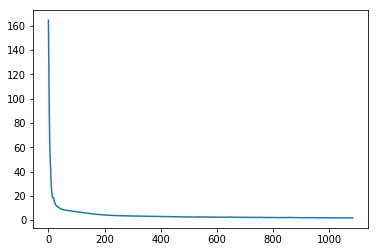

In [11]:
plt.plot(losses)

In [12]:
outp = np.array(sess.run(outputs, feed_dict={X: Songs}))
outp.shape

(127, 68, 14)

In [13]:
outp = np.rollaxis(outp, 1)
outp.shape

(68, 127, 14)

Кузнечик и предсказания кузнечика!

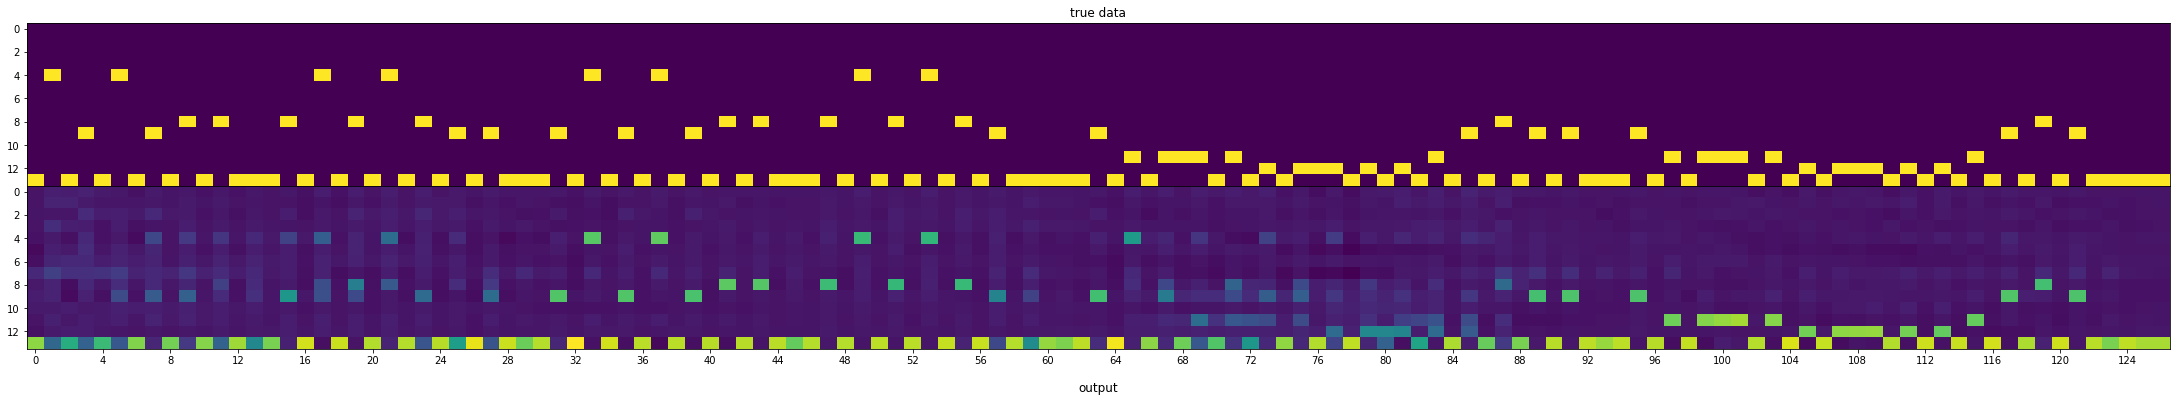

In [14]:
draw(Songs[0, 1:, :], outp[0, :, :], scalex=192.0 / 5, scaley=30.0 / 5)

Интересно, что на третьей четверти подсвечен вариант ещё раз копировать вторую, но он уже не так уверен, как на второй, где он был уверен в том, что нужно копировать

In [15]:
readings = np.array(sess.run(readings_log, feed_dict={X: Songs}))
readings.shape

(127, 68, 80)

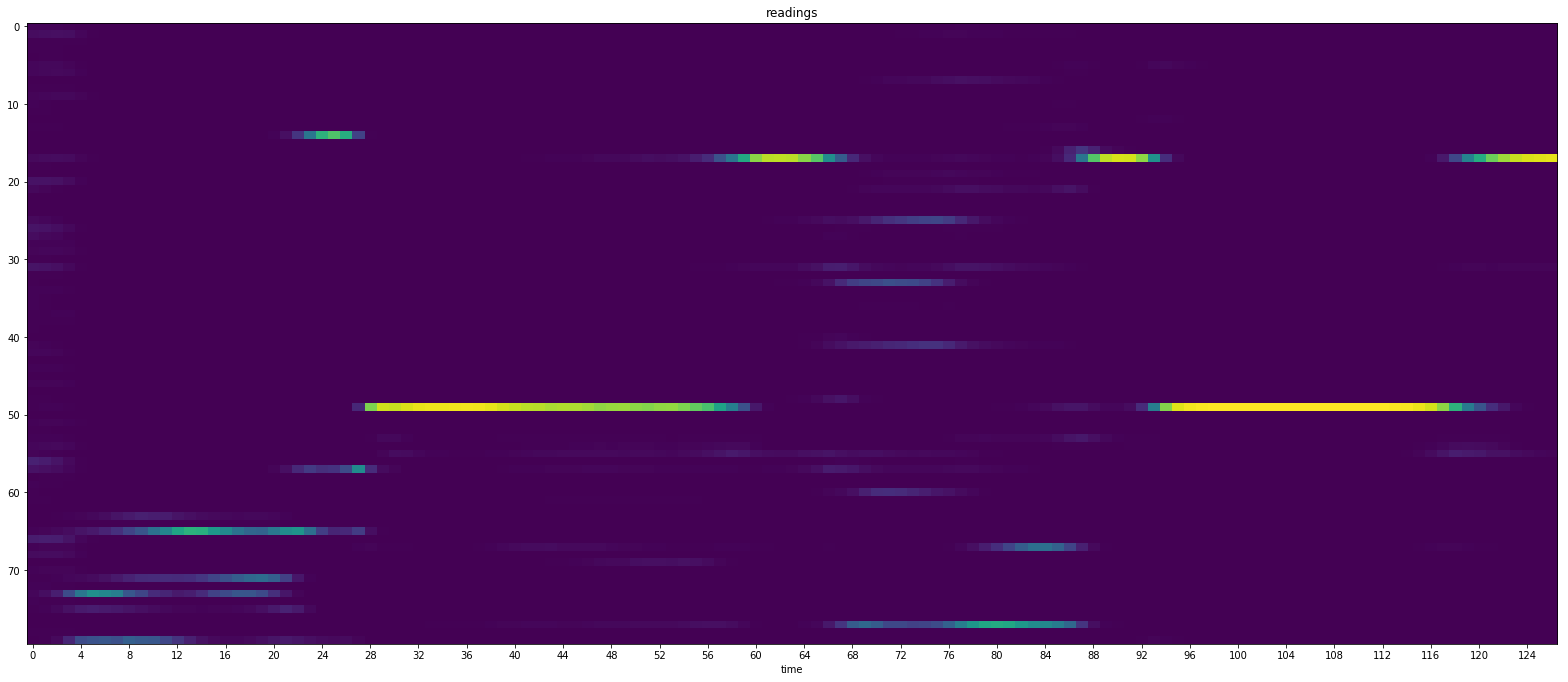

In [16]:
drawr(readings[:, 0, :], scalex=192.0 / 7, scaley=80.0 / 7)

Похоже, это более адекватный результат, чем обычно... Ну, снова посмотрим, куда в историю он как часто смотрит (по всем песенкам):

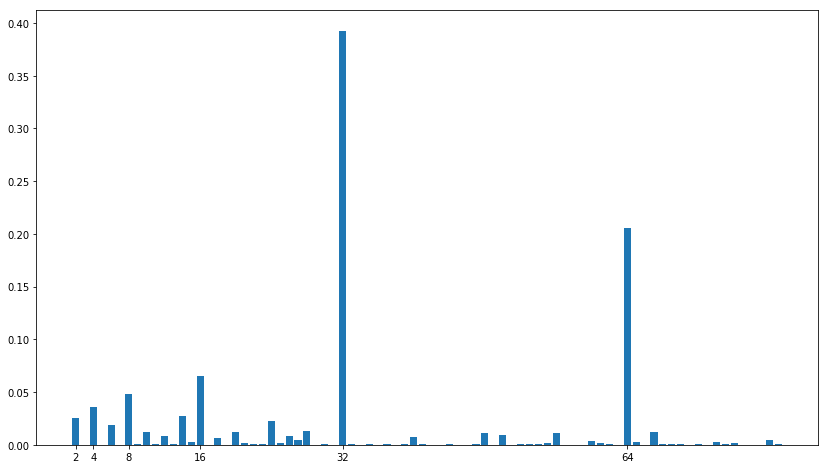

In [25]:
plt.figure(figsize=(14, 8))
plt.bar(np.arange(2, 82)[::-1], readings[:, :, :].mean(axis=0).mean(axis=0))
plt.xticks(2**np.arange(1, 7))
plt.show()

Итак, вот теперь результат интерпретируем. Возникает вопрос...

1) что за фигня с кросс-энтропией, где lstm похоже обучился запоминать 35 песенок через обычный lstm-слой вместо использования памяти

2) почему при тестах без этого transform-слоя были такие же столбики на.. 31 и 63 индексе?!? 

Посмотрим-ка на другую мелодию:

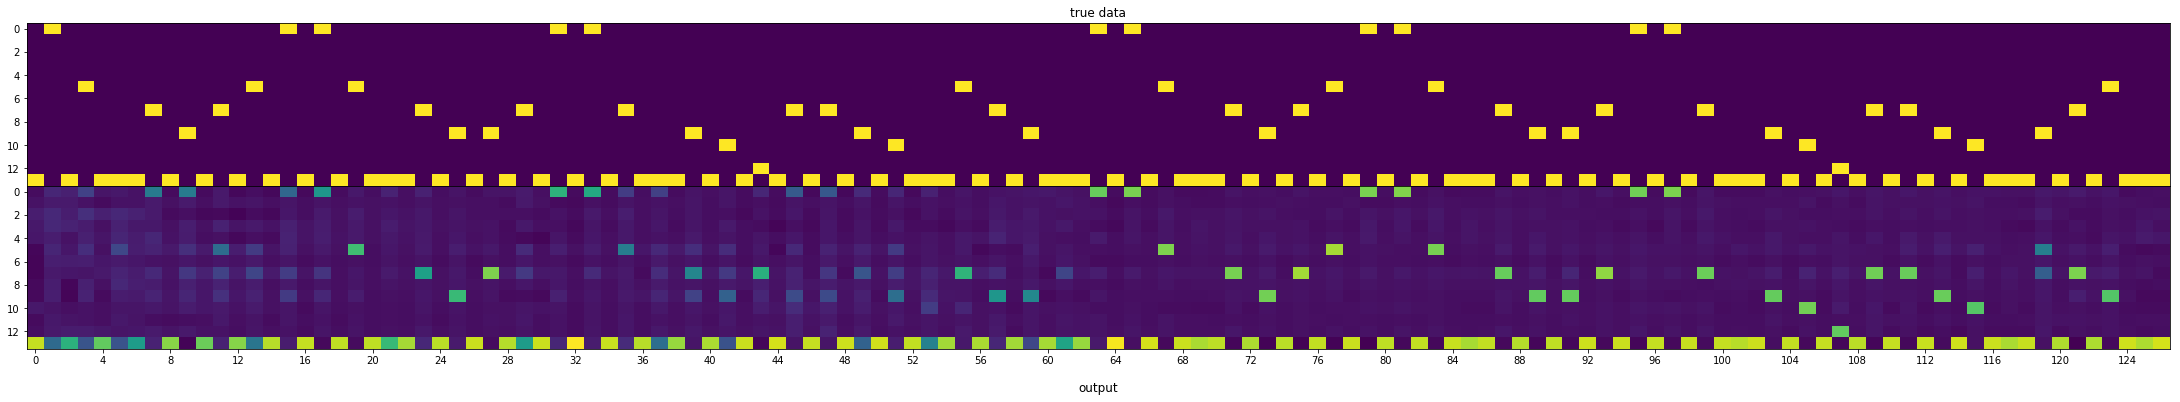

In [27]:
draw(Songs[20, 1:, :], outp[20, :, :], scalex=192.0 / 5, scaley=30.0 / 5)

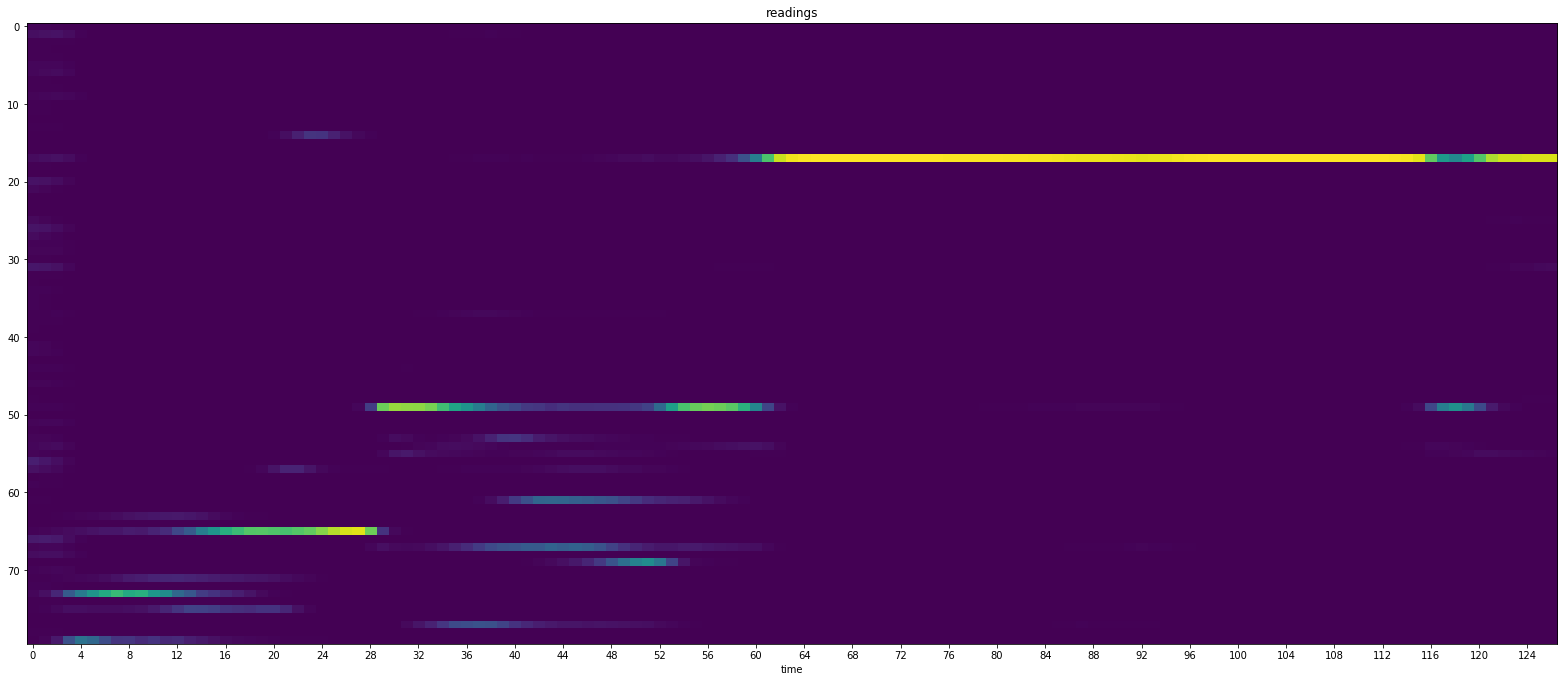

In [29]:
drawr(readings[:, 20, :], scalex=192.0 / 7, scaley=80.0 / 7)

Замечательная картинка!

# Генерация

За исключением того, что граф вычислений TF нужно прогонять 128 раз, сам алгоритм тут адекватный: получаем распределение, сэмплируем, фиксируем результат. Дальше этот результат будет попадать в историю и использоваться через периоды времени - то, чего и хотелось бы добиться.

In [42]:
notes = np.zeros((68, 128, 14))
notes[np.arange(68), np.zeros(68, dtype=int), np.random.randint(0, 13, size=68)] = 1  # first note is one and random

In [43]:
for t in range(127):
    outp = np.array(sess.run(outputs, feed_dict={X: notes}))
    
    # generate next note from output probabilities
    next_note = np.zeros((68, 14))
    for i in range(68):
        next_note[i, np.random.choice(np.arange(14), p=outp[t, i])] = 1
    
    # write chosen notes
    notes[:, t+1, :] = next_note

In [44]:
rs = np.array(sess.run(readings_log, feed_dict={X: notes}))

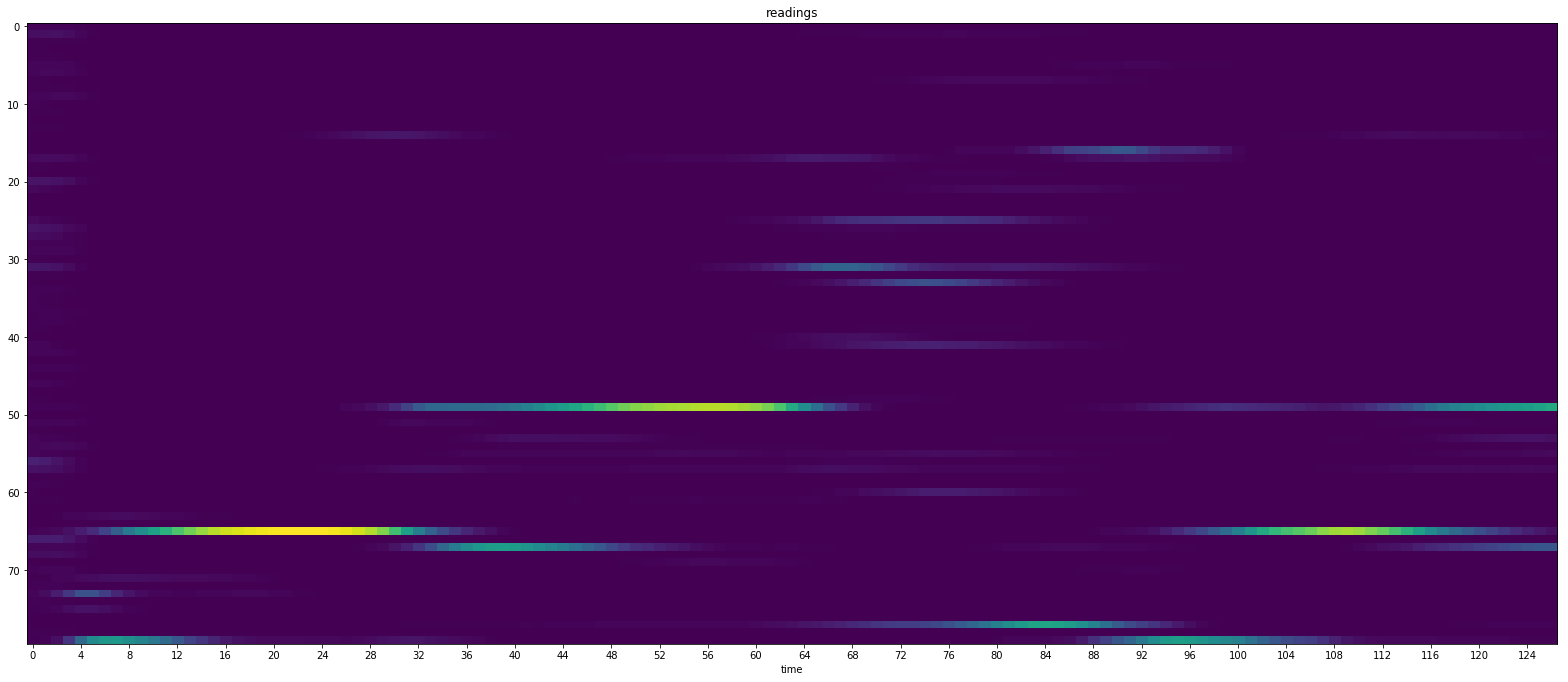

In [61]:
drawr(rs.mean(axis=1), scalex=192.0 / 7, scaley=80.0 / 7)

Да, тут пока фигня...

In [32]:
#notes = notes[:, :, :-1]  # delete "pause notes"

In [41]:
# saving mid to files
#for i in range(68):
#    ms = MySong(notes[i])
#    ms.finish()
#    ms.save_file(".\HistoryUser MSE\HU (2-layer LSTM) united (1-layer LSTM) with transformed inputs (1-layer LSTM) trained on 35 songs - ex" + str(i))